# Optimal Portfolio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Efficient Frontier

Пояснение выбора списка активов: 

+ Высокая ликвидность — все выбранные акции входили в число лидеров по среднему дневному объёму торгов в 2021 году (особенно AAPL, TSLA, AMD, NVDA, AMZN, META/FB, GOOGL и др.). Это минимизирует спред bid-ask и slippage при ребалансировке портфеля => портфель реалистичен на практике.
+ Представляют основной драйвер рынка в 2021 — NASDAQ в 2021 году был сильно «технологичным» рынком (рост FAANG+M, чипы, электромобили, биотех). Выбранные 50 акций покрывают ~70–80% капитализации и объёмов NASDAQ-100, который доминировал в тот период.
+ Хорошая диверсификация внутри технологического рынка:
    + Крупные платформы / потребительский сектор: AAPL, AMZN, META, GOOGL/GOOG, NFLX
    + Полупроводники / чипы: NVDA, AMD, INTC, QCOM, AVGO, ASML, MU, LRCX, KLAC
    + Биотехнологии / здравоохранение: AMGN, GILD, REGN, ILMN, DXCM
    + Потребительские / ритейл / сервисы: COST, PEP, MDLZ, ORLY, DLTR
    + Телеком / медиа: CMCSA, CHTR
    + Другие: PAYX, ADP, CTSH, CSX, BKR и т.д.

#### Data load & preprocessing

In [2]:
raw_data = pd.read_csv("data/raw/NASDAQ_FULL_2021_Close.csv")
raw_data.head()

,Date,AAPL,ADBE,ADI,ADP,ADSK,AMD,AMGN,AMZN,ASML,...,NFLX,NVDA,NXPI,ORLY,PAYX,PEP,PYPL,QCOM,REGN,TSLA
0,2021-01-04,125.974472,485.339996,133.808731,152.303543,296.839996,92.300003,193.642517,159.331497,477.949219,...,52.285999,13.076726,148.497253,30.264668,78.469963,123.652855,231.385101,133.337646,480.196747,243.256668
1,2021-01-05,127.531975,485.690002,136.200485,151.879822,301.700012,92.769997,194.582214,160.925507,483.072784,...,52.080002,13.367159,151.823929,30.085333,78.174713,124.021347,234.368210,136.866333,480.783478,245.036667
2,2021-01-06,123.239044,466.309998,136.814453,151.348007,302.869995,90.330002,199.272507,156.919006,468.600555,...,50.049000,12.579126,154.618973,31.011999,79.156013,122.504295,226.306839,135.752930,467.497162,251.993332
3,2021-01-07,127.444351,477.739990,142.596786,152.204361,315.200012,95.160004,199.930344,158.108002,479.316162,...,50.889000,13.306579,160.364944,31.326668,79.486008,122.110023,234.497894,139.802490,478.545929,272.013336
4,2021-01-08,128.544403,485.100006,143.632263,154.187531,319.850006,94.580002,203.749207,159.134995,486.303711,...,51.040001,13.239518,160.401611,31.861334,79.911537,123.575684,241.900803,140.646515,495.979248,293.339996


In [3]:
raw_data.drop(columns=["Date"], inplace=True)
raw_data.head()

,AAPL,ADBE,ADI,ADP,ADSK,AMD,AMGN,AMZN,ASML,AVGO,...,NFLX,NVDA,NXPI,ORLY,PAYX,PEP,PYPL,QCOM,REGN,TSLA
0,125.974472,485.339996,133.808731,152.303543,296.839996,92.300003,193.642517,159.331497,477.949219,38.253105,...,52.285999,13.076726,148.497253,30.264668,78.469963,123.652855,231.385101,133.337646,480.196747,243.256668
1,127.531975,485.690002,136.200485,151.879822,301.700012,92.769997,194.582214,160.925507,483.072784,38.512192,...,52.080002,13.367159,151.823929,30.085333,78.174713,124.021347,234.368210,136.866333,480.783478,245.036667
2,123.239044,466.309998,136.814453,151.348007,302.869995,90.330002,199.272507,156.919006,468.600555,38.274708,...,50.049000,12.579126,154.618973,31.011999,79.156013,122.504295,226.306839,135.752930,467.497162,251.993332
3,127.444351,477.739990,142.596786,152.204361,315.200012,95.160004,199.930344,158.108002,479.316162,39.887695,...,50.889000,13.306579,160.364944,31.326668,79.486008,122.110023,234.497894,139.802490,478.545929,272.013336
4,128.544403,485.100006,143.632263,154.187531,319.850006,94.580002,203.749207,159.134995,486.303711,40.090115,...,51.040001,13.239518,160.401611,31.861334,79.911537,123.575684,241.900803,140.646515,495.979248,293.339996


In [4]:
raw_data.isna().sum(axis=0).value_counts().sort_index()

0    50
Name: count, dtype: int64

Пропусков в данных нет.

In [5]:
# Удаление активов с аномальными ценами (отрицательные или нулевые)
# Цены акций не могут быть отрицательными.

has_non_positive_price = (raw_data <= 0).any(axis=0)
non_positive_tickers = has_non_positive_price[has_non_positive_price].index.tolist()

print(f"Total tickers with non-positive price found: {len(non_positive_tickers)}")
print(f"Examples of non-positive tickers: {non_positive_tickers[:10]} ...")

Total tickers with non-positive price found: 0
Examples of non-positive tickers: [] ...


In [6]:
raw_data.to_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv", index=False)

#### Start

In [7]:
try:
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
    print(f"Data loaded successfully with {data.shape[0]} rows (days) and {data.shape[1]} assets.")
except FileNotFoundError:
    print("Error: file NASDAQ_FULL_2021_Cleaned_Imputed.csv not found.")

Data loaded successfully with 252 rows (days) and 50 assets.


Log returns:

In [8]:
eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Drop the first row which contains NaN values (as there is no P_{t-1} for the first day)
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


Расчёт средних доходностей и ковариационной матрицы (аннуализированные)

In [9]:
num_trading_days = 251
tickers = [
    'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO',
    'BIDU', 'BKNG', 'BKR', 'CDNS', 'CHTR', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTSH',
    'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN',
    'INTC', 'ISRG', 'KDP', 'KLAC', 'LRCX', 'MAR', 'MDLZ', 'META', 'MNST', 'MU',
    'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PEP', 'PYPL', 'QCOM', 'REGN', 'TSLA',
]
mu = log_returns.mean() * num_trading_days  # Ожидаемые доходности
Sigma = log_returns.cov() * num_trading_days  # Ковариационная матрица
n_assets = len(tickers)
print(f"Number of assets: {n_assets}")
print("Expected returns (annualized):\n", mu.head())
print("Covariance matrix (annualized) sample:\n", Sigma.iloc[:5, :5])

Number of assets: 50
Expected returns (annualized):
 AAPL    0.347595
ADBE    0.180703
ADI     0.227048
ADP     0.421902
ADSK   -0.029052
dtype: float64
Covariance matrix (annualized) sample:
           AAPL      ADBE       ADI       ADP      ADSK
AAPL  0.062257  0.044187  0.032719  0.017400  0.035749
ADBE  0.044187  0.087143  0.039055  0.020657  0.052380
ADI   0.032719  0.039055  0.073687  0.018572  0.045712
ADP   0.017400  0.020657  0.018572  0.035125  0.020560
ADSK  0.035749  0.052380  0.045712  0.020560  0.121572


In [10]:
import scipy.optimize as sco

In [11]:
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [12]:
def min_vol_for_return(target_return, mean_returns, cov_matrix, allow_short=True):
    n = len(mean_returns)
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Сумма весов = 1
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_return}  # Доходность = target
    )
    bounds = None if allow_short else tuple((0, 1) for _ in range(n))
    result = sco.minimize(
        portfolio_volatility,
        x0=np.array([1.0 / n] * n),
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result

Функция для построения эффективного фронта:

In [13]:
def generate_efficient_frontier(mean_returns, cov_matrix, allow_short=True, num_points=100):
    min_ret = mean_returns.min()
    max_ret = mean_returns.max() * (2 if allow_short else 1)  # Для шортов фронт шире
    target_returns = np.linspace(min_ret, max_ret, num_points)
    risks = []
    returns = []
    for tr in target_returns:
        opt = min_vol_for_return(tr, mean_returns, cov_matrix, allow_short)
        if opt.success:
            returns.append(tr)
            risks.append(opt.fun)
    return np.array(returns), np.array(risks)

Функция для поиска портфеля с минимальным риском

In [14]:
def min_risk_portfolio(mean_returns, cov_matrix, allow_short=True):
    n = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = None if allow_short else tuple((0, 1) for _ in range(n))
    result = sco.minimize(
        portfolio_volatility,
        x0=np.array([1.0 / n] * n),
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints]
    )
    if result.success:
        min_risk = result.fun
        min_return = np.dot(result.x, mean_returns)
        return min_return, min_risk, result.x
    else:
        raise ValueError("Optimization failed for min risk portfolio")

Построение эффективного фронта без ограничений на короткие позиции

In [15]:
returns_short_allowed, risks_short_allowed = generate_efficient_frontier(mu, Sigma, allow_short=True)

Портфель с минимальным риском (без ограничений на шорты)

In [16]:
min_ret_short, min_risk_short, w_min_short = min_risk_portfolio(mu, Sigma, allow_short=True)

Построение эффективного фронта с запретом коротких позиций

In [17]:
returns_no_short, risks_no_short = generate_efficient_frontier(mu, Sigma, allow_short=False)

Портфель с минимальным риском (без шортов)

In [18]:
min_ret_no_short, min_risk_no_short, w_min_no_short = min_risk_portfolio(mu, Sigma, allow_short=False)

Равновзвешенный портфель

In [19]:
w_equal = np.array([1.0 / n_assets] * n_assets)
ret_equal = np.dot(w_equal, mu)
risk_equal = portfolio_volatility(w_equal, Sigma)

Портфель индекса рынка (капитализационно-взвешенный на основе данных на 31.12.2021)

Рыночные капитализации на 31.12.2021 (из внешнего источника Polygon API)

In [20]:
market_caps = {
'AAPL': 2913283915290.0, 'ADBE': 269807147999.99997, 'ADI': 92337372217.44, 'ADP': 103904877076.36,
'ADSK': 61854325126.229996, 'AMD': 173775144474.5, 'AMGN': 126717929972.94, 'AMZN': 1691002595270.8,
'ASML': 323610586138.08, 'AVGO': 274730467046.87997, 'BIDU': 51787650253.25, 'BKNG': 98520745116.55,
'BKR': 20931431283.0, 'CDNS': 51645225350.0, 'CHTR': 116892401515.78, 'CMCSA': 229953896854.85,
'COST': 251736622302.2, 'CSCO': 267269727390.34998, 'CSX': 83396176253.6, 'CTSH': 46600333840.479996,
'DLTR': 31610825410.680004, 'DXCM': 52042286156.3, 'EA': 37302394061.700005, 'EBAY': 41629251436.5,
'EXC': 56507635377.119995, 'GILD': 91080787532.42, 'GOOG': 1920660855398.4602, 'GOOGL': 1922950841177.76,
'IDXX': 55833199123.68, 'ILMN': 59462772000.0, 'INTC': 209450500000.0, 'ISRG': 128355204157.3,
'KDP': 52266064354.84, 'KLAC': 65214209388.15, 'LRCX': 101255382947.55, 'MAR': 53815875444.0,
'MDLZ': 92500602072.92, 'FB': 935644813206.6001, 'MNST': 50818520604.600006, 'MU': 104343812119.35,
'NFLX': 266852119753.36002, 'NVDA': 735275000000.0, 'NXPI': 60574275457.22, 'ORLY': 47584644607.08,
'PAYX': 49243329135.0, 'PEP': 240180642728.53, 'PYPL': 221568331835.76, 'QCOM': 204814400000.0,
'REGN': 67915566727.36, 'ROST': 40378522115.8, 'SBUX': 137229204000.0, 'TMUS': 144865228293.42,
'TSLA': 1061287010296.5599, 'TXN': 174056954078.09, 'VRTX': 55833725584.799995, 'WBA': 45063364732.159996,
'XEL': 36468336089.0
}
total_market_cap = sum(market_caps.values())
w_market = np.array([market_caps.get(t, 0) / total_market_cap for t in tickers])
ret_market = np.dot(w_market, mu)
risk_market = portfolio_volatility(w_market, Sigma)

Визуализация эффективных фронтов и сравнение

In [21]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

Эффективный фронт без шортов

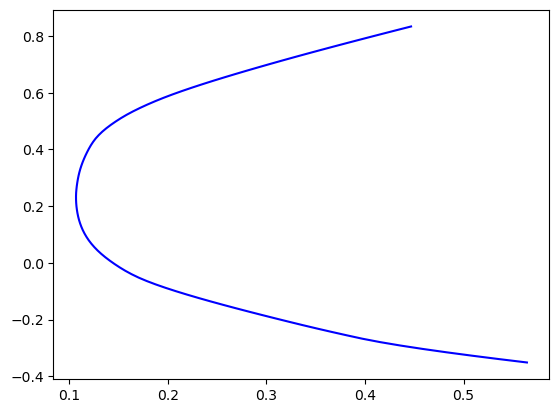

In [22]:
plt.plot(risks_no_short, returns_no_short, 'b-', label='Efficient Frontier (No Short Sales)')

Эффективный фронт с шортами

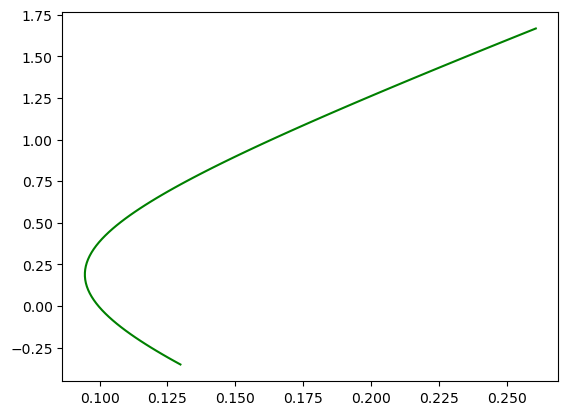

In [23]:
plt.plot(risks_short_allowed, returns_short_allowed, 'g-', label='Efficient Frontier (Short Sales Allowed)')

Портфели с минимальным риском

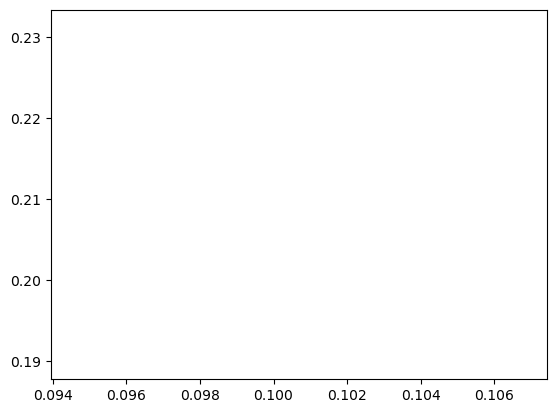

In [24]:
plt.scatter(min_risk_no_short, min_ret_no_short, color='blue', marker='', s=200, label='Min Risk Portfolio (No Short)')
plt.scatter(min_risk_short, min_ret_short, color='green', marker='', s=200, label='Min Risk Portfolio (Short Allowed)')

Равновзвешенный портфель

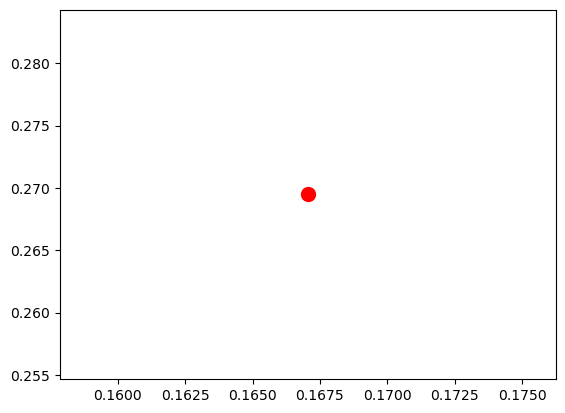

In [25]:
plt.scatter(risk_equal, ret_equal, color='red', marker='o', s=100, label='Equal Weight Portfolio')

Портфель индекса рынка

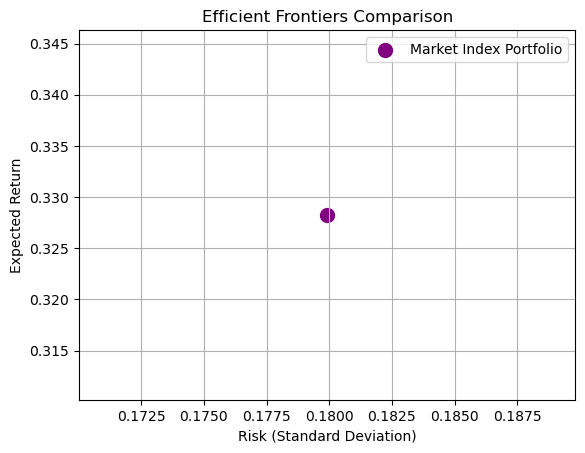

In [26]:
plt.scatter(risk_market, ret_market, color='purple', marker='o', s=100, label='Market Index Portfolio')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontiers Comparison')
plt.legend()
plt.grid(True)
plt.show()

Сравнение эффективных фронтов и выводы

# Task 2

## Selection of 10 assets

In [27]:
# Annualized volatility
vols = np.sqrt(np.diag(Sigma))

# Sharpe ratios (risk-free rate = 0)
sharpe_ratios = mu / vols

# Select top 10 assets by Sharpe ratio
top_10_tickers = sharpe_ratios.sort_values(ascending=False).head(10).index.tolist()

print("Selected 10 assets based on Sharpe ratio:")
print(top_10_tickers)

# Subset mean returns and covariance matrix
mu_10 = mu.loc[top_10_tickers]
Sigma_10 = Sigma.loc[top_10_tickers, top_10_tickers]

Selected 10 assets based on Sharpe ratio:
['PAYX', 'COST', 'GOOG', 'ORLY', 'ADP', 'GOOGL', 'EXC', 'CSCO', 'NVDA', 'AVGO']


## Efficient frontiers for 10 assets

In [28]:
# Short sales allowed
returns_10_short, risks_10_short = generate_efficient_frontier(
    mu_10, Sigma_10, allow_short=True
)
min_ret_10_short, min_risk_10_short, _ = min_risk_portfolio(
    mu_10, Sigma_10, allow_short=True
)

# No short sales
returns_10_no_short, risks_10_no_short = generate_efficient_frontier(
    mu_10, Sigma_10, allow_short=False
)
min_ret_10_no_short, min_risk_10_no_short, _ = min_risk_portfolio(
    mu_10, Sigma_10, allow_short=False
)

## Plot comparison

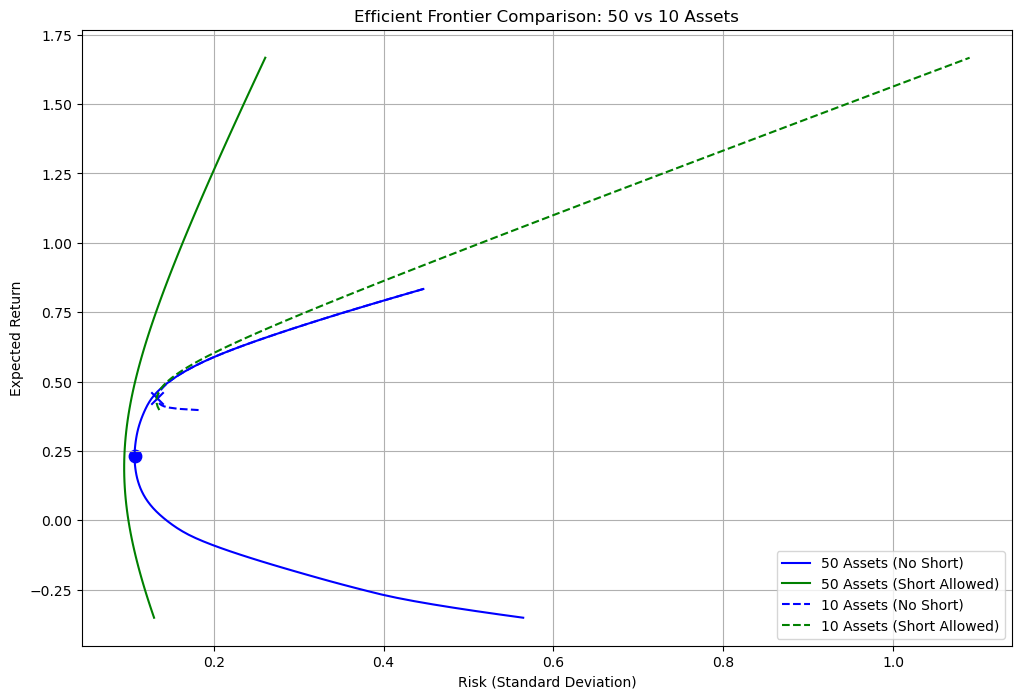

In [29]:
plt.figure(figsize=(12, 8))

# 50 assets
plt.plot(risks_no_short, returns_no_short, 'b-', 
         label='50 Assets (No Short)')
plt.plot(risks_short_allowed, returns_short_allowed, 'g-', 
         label='50 Assets (Short Allowed)')

# 10 assets
plt.plot(risks_10_no_short, returns_10_no_short, 'b--', 
         label='10 Assets (No Short)')
plt.plot(risks_10_short, returns_10_short, 'g--', 
         label='10 Assets (Short Allowed)')

# Minimum variance points
plt.scatter(min_risk_no_short, min_ret_no_short, color='blue', s=80)
plt.scatter(min_risk_10_no_short, min_ret_10_no_short, color='blue', marker='x', s=80)

plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier Comparison: 50 vs 10 Assets')
plt.legend()
plt.grid(True)
plt.show()

# Task 3

## Utility maximization

In [30]:
def negative_utility(weights, mean_returns, cov_matrix, gamma):
    port_return = np.dot(weights, mean_returns)
    port_var = np.dot(weights.T, np.dot(cov_matrix, weights))
    utility = port_return - 0.5 * gamma * port_var
    return -utility  # minimize negative utility


def optimal_portfolio_utility(mean_returns, cov_matrix, gamma, allow_short=True):
    n = len(mean_returns)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = None if allow_short else tuple((0, 1) for _ in range(n))

    result = sco.minimize(
        negative_utility,
        x0=np.array([1.0 / n] * n),
        args=(mean_returns, cov_matrix, gamma),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraints]
    )

    if not result.success:
        raise ValueError("Utility optimization failed")

    weights = result.x
    ret = np.dot(weights, mean_returns)
    risk = portfolio_volatility(weights, cov_matrix)
    return ret, risk, weights

## Personal optimal portfolio

In [31]:
# Short sales allowed
ret_u_short, risk_u_short, w_u_short = optimal_portfolio_utility(
    mu, Sigma, 5, allow_short=True
)

# No short sales
ret_u_no_short, risk_u_no_short, w_u_no_short = optimal_portfolio_utility(
    mu, Sigma, 5, allow_short=False
)

print("Personal optimal portfolio (Short allowed):")
print(pd.Series(w_u_short, index=tickers).sort_values(ascending=False).head(10))

print("\nPersonal optimal portfolio (No short):")
print(pd.Series(w_u_no_short, index=tickers).sort_values(ascending=False).head(10))

Personal optimal portfolio (Short allowed):
GOOG    5.390184
AVGO    2.888673
CSCO    1.887973
KLAC    1.867330
PAYX    1.732630
ORLY    1.710760
NVDA    1.688733
GILD    1.650425
IDXX    1.610359
EXC     1.373466
dtype: float64

Personal optimal portfolio (No short):
NVDA     3.899661e-01
ORLY     2.626291e-01
GOOG     1.845429e-01
PAYX     1.628619e-01
GOOGL    2.949143e-15
PYPL     1.359121e-15
MU       7.148981e-16
ADBE     6.353362e-16
AMZN     5.819571e-16
QCOM     5.769464e-16
dtype: float64


## VaR and CVaR estimation

In [32]:
def portfolio_returns(weights, returns_df):
    return returns_df @ weights


def var_cvar(port_returns, alpha=0.05):
    var = np.quantile(port_returns, alpha)
    cvar = port_returns[port_returns <= var].mean()
    return var, cvar


# Portfolio returns
port_ret_short = portfolio_returns(w_u_short, log_returns[tickers])
port_ret_no_short = portfolio_returns(w_u_no_short, log_returns[tickers])

VaR_short, CVaR_short = var_cvar(port_ret_short)
VaR_no_short, CVaR_no_short = var_cvar(port_ret_no_short)

print("\nRisk measures (daily):")
print(f"Short allowed:   VaR = {VaR_short:.4f}, CVaR = {CVaR_short:.4f}")
print(f"No short sales: VaR = {VaR_no_short:.4f}, CVaR = {CVaR_no_short:.4f}")


Risk measures (daily):
Short allowed:   VaR = -0.0906, CVaR = -0.1260
No short sales: VaR = -0.0201, CVaR = -0.0298


## Plot Comparison

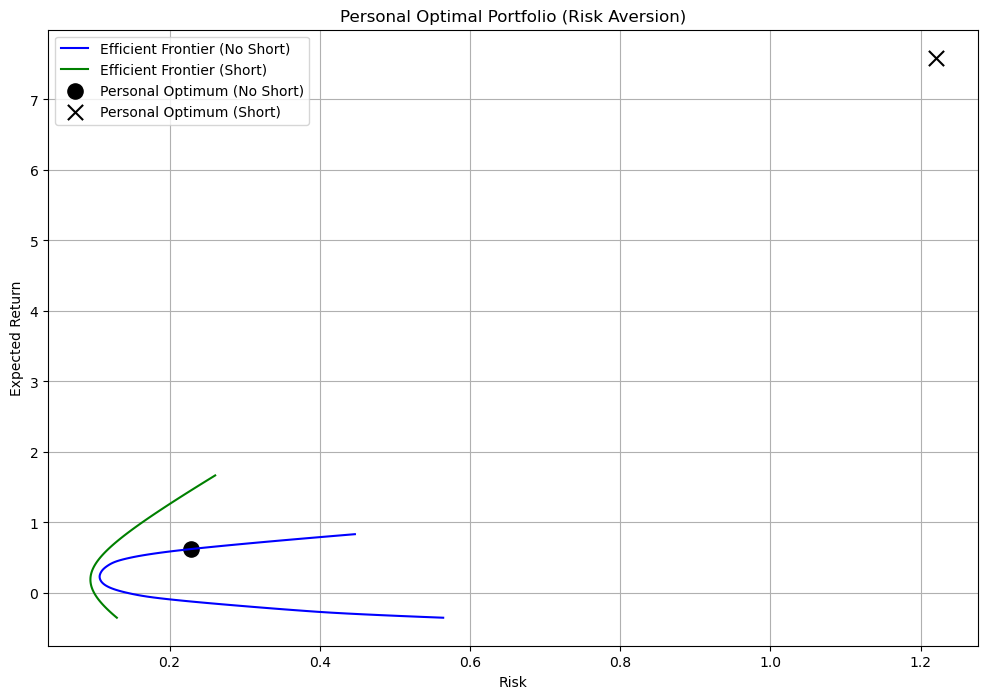

In [33]:
plt.figure(figsize=(12, 8))

plt.plot(risks_no_short, returns_no_short, 'b-', label='Efficient Frontier (No Short)')
plt.plot(risks_short_allowed, returns_short_allowed, 'g-', label='Efficient Frontier (Short)')

plt.scatter(risk_u_no_short, ret_u_no_short, 
            color='black', marker='o', s=120, label='Personal Optimum (No Short)')
plt.scatter(risk_u_short, ret_u_short, 
            color='black', marker='x', s=120, label='Personal Optimum (Short)')

plt.xlabel('Risk')
plt.ylabel('Expected Return')
plt.title('Personal Optimal Portfolio (Risk Aversion)')
plt.legend()
plt.grid(True)
plt.show()
